In [29]:
import sys
import os
import pandas as pd
import joblib
import warnings

In [30]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [31]:
# Aller au dossier racine du projet
project_root = os.path.abspath("..")  # Remonte au dossier principal du projet
src_path = os.path.join(project_root, "src")

# Ajouter le chemin src/ au path Python (évite les doublons)
if src_path not in sys.path:
    sys.path.append(src_path)

# Prédictions
model_path = os.path.abspath(os.path.join("..", "models", "linear_regression.pkl"))
model = joblib.load(model_path)

In [32]:
from data_processing.load_data import load_data
from data_processing.clean_data import clean_data_runs, clean_data_races, clean_before_fitting
from data_processing.merge_data import merge_data
from data_processing.preprocess_data import preprocess_data, split_train_test
from ml_models.linear_regression import train_linear_regression
from metrics.performance_metrics import prepare_predictions, compute_top_prediction, finalize_dataframe, compute_accuracy
from data_processing.output_to_csv import output_to_csv

# Charger les datasets
print("Chargement des données...")
df_runs = load_data("../data/raw/runs.csv")
df_races = load_data("../data/raw/races.csv")

# Nettoyage des données
print("Nettoyage des données...")
clean_data_runs(df_runs)
clean_data_races(df_races)

df = merge_data(df_runs, df_races)
clean_before_fitting(df)

# Prétraitement des données
print("Prétraitement des données...")
df = preprocess_data(df)

# Split en train/test
print("Séparation des données...")
y_train, y_test, X_train, X_test, df_train, df_test = split_train_test(df, train_ratio=0.8)

df_test_original = df_test.copy()

# Entraînement du modèle
print("Entraînement du modèle de régression linéaire...")
train_linear_regression(X_train, y_train)

# Faire des prédictions sur X_test
y_predict = model.predict(X_test)

# Prédiction et évaluation
df = prepare_predictions(df_test_original, y_predict)
df = compute_top_prediction(df)
df_stats = finalize_dataframe(df)

accuracy = compute_accuracy(df_stats)

# Output to csv for analysis
output_to_csv(df_stats, 'statistiques')

print(f"✅ Précision basée sur les courses : {accuracy:.2f}%")

Chargement des données...
Nettoyage des données...
Prétraitement des données...
Séparation des données...
Entraînement du modèle de régression linéaire...
Successfully trained linear_regression model
✅ Précision basée sur les courses : 23.88%


In [33]:
df.head()

,horse_id,won,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,venue_ST,...,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan,y_predict,top_prediction
race_id,,,,,,,,,,,,,,,,,,,,,
5079,1343,1.0,3,63,1194.0,108,13,42.0,7.6,1,...,0,0,1,0,0,0,0,0,0.040316,0
5079,2216,0.0,3,62,1157.0,115,12,10.0,2.6,1,...,0,0,1,0,0,0,0,0,0.110638,1
5080,2832,0.0,3,100,1110.0,133,10,12.0,3.9,1,...,0,0,1,0,0,0,0,0,0.124941,0
5080,1236,0.0,4,95,1026.0,126,9,9.4,2.5,1,...,0,0,1,0,0,0,0,0,0.120047,0
5080,1278,0.0,3,94,1104.0,127,14,11.0,3.9,1,...,0,0,1,0,0,0,0,0,0.118587,0


In [34]:
df_stats = df_stats.reset_index()
df_stats

,race_id,horse_id,won,y_predict,top_prediction,accuracy
0,5079,1343,1,0.040316,0,False
1,5079,2216,0,0.110638,1,False
2,5080,2832,0,0.124941,0,False
3,5080,1236,0,0.120047,0,False
4,5080,1278,0,0.118587,0,False
...,...,...,...,...,...,...
15885,6348,1238,0,-0.068531,0,False
15886,6348,985,0,-0.070053,0,False
15887,6348,3147,0,-0.061670,0,False
15888,6348,1982,0,0.122784,0,False


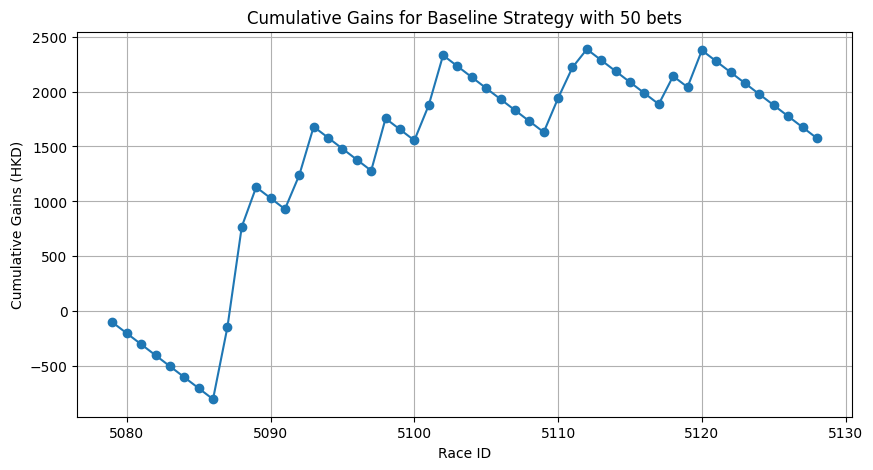

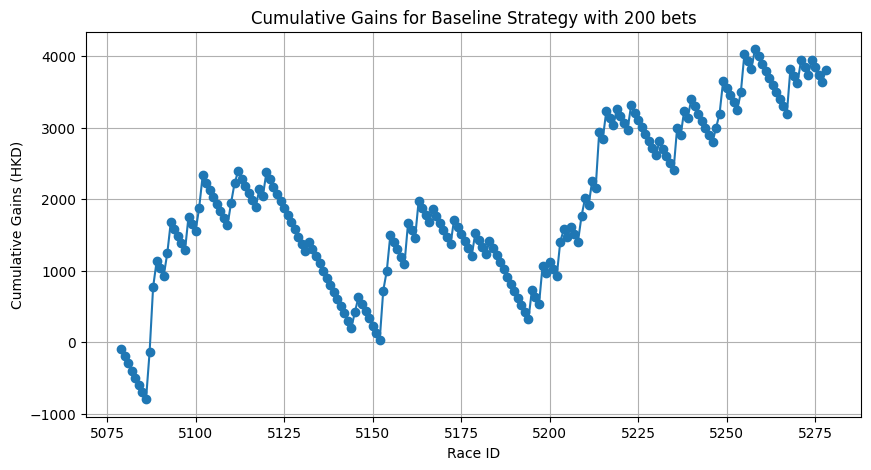

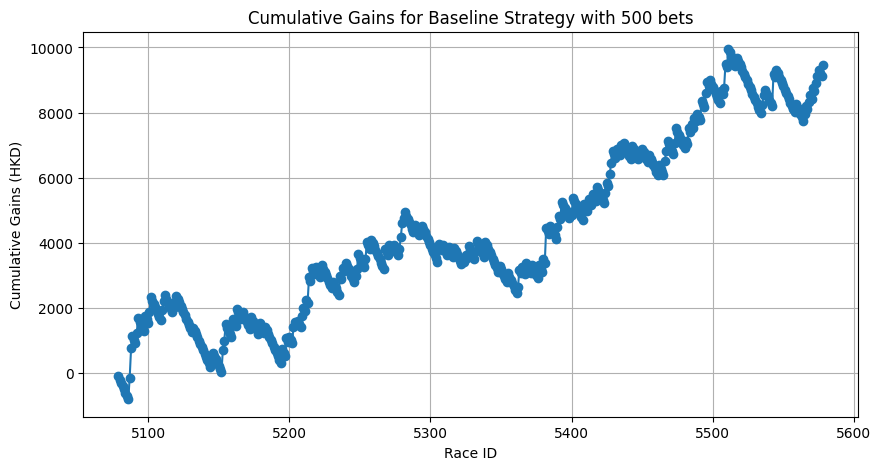

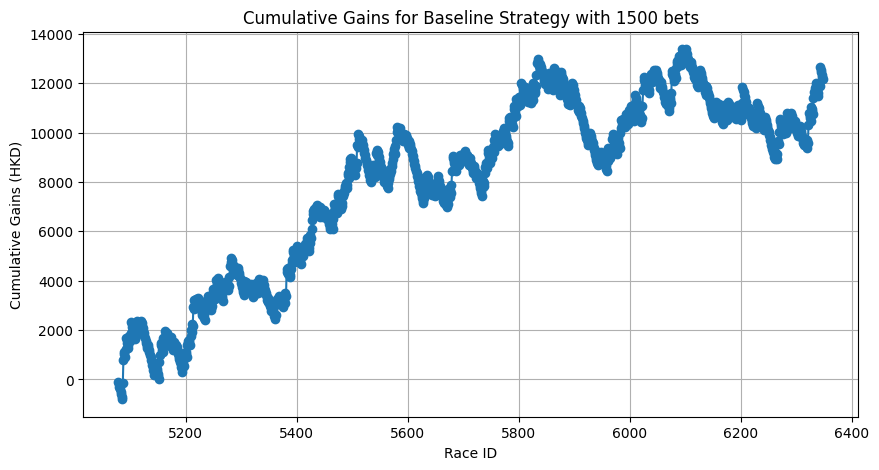

In [35]:
from data_processing.preprocess_data import fetch_winning_dividends
from investment_strategies.baseline_strategy import baseline_strategy
from visualization.plot_results import plot_cumulative_gains 

for i in [50,200,500,1500]:
    df = fetch_winning_dividends(df_stats)
    df = baseline_strategy(df, 100, i)

    plot_cumulative_gains(df, i, "Baseline Strategy")